In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [2]:
cardioRaw=pd.read_parquet('./cardio.parquet')

Age | Objective Feature | age | int (days)

Height | Objective Feature | height | int (cm) |

Weight | Objective Feature | weight | float (kg) |

Gender | Objective Feature | gender | categorical code |

Systolic blood pressure | Examination Feature | ap_hi | int |

Diastolic blood pressure | Examination Feature | ap_lo | int |

Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |

Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |

Smoking | Subjective Feature | smoke | binary |

Alcohol intake | Subjective Feature | alco | binary |

Physical activity | Subjective Feature | active | binary |

Presence or absence of cardiovascular disease | Target Variable | cardio | binary |


In [3]:
# Explore dataset structure
print("Dataset shape:", cardioRaw.shape)
cardioRaw.head()


Dataset shape: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
# Check for missing values
print("Missing values:")
print(cardioRaw.isnull().sum())


Missing values:
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [5]:
# Check data types
print("Data types:")
print(cardioRaw.dtypes)


Data types:
id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object


In [6]:
# Basic statistics
cardioRaw.describe()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


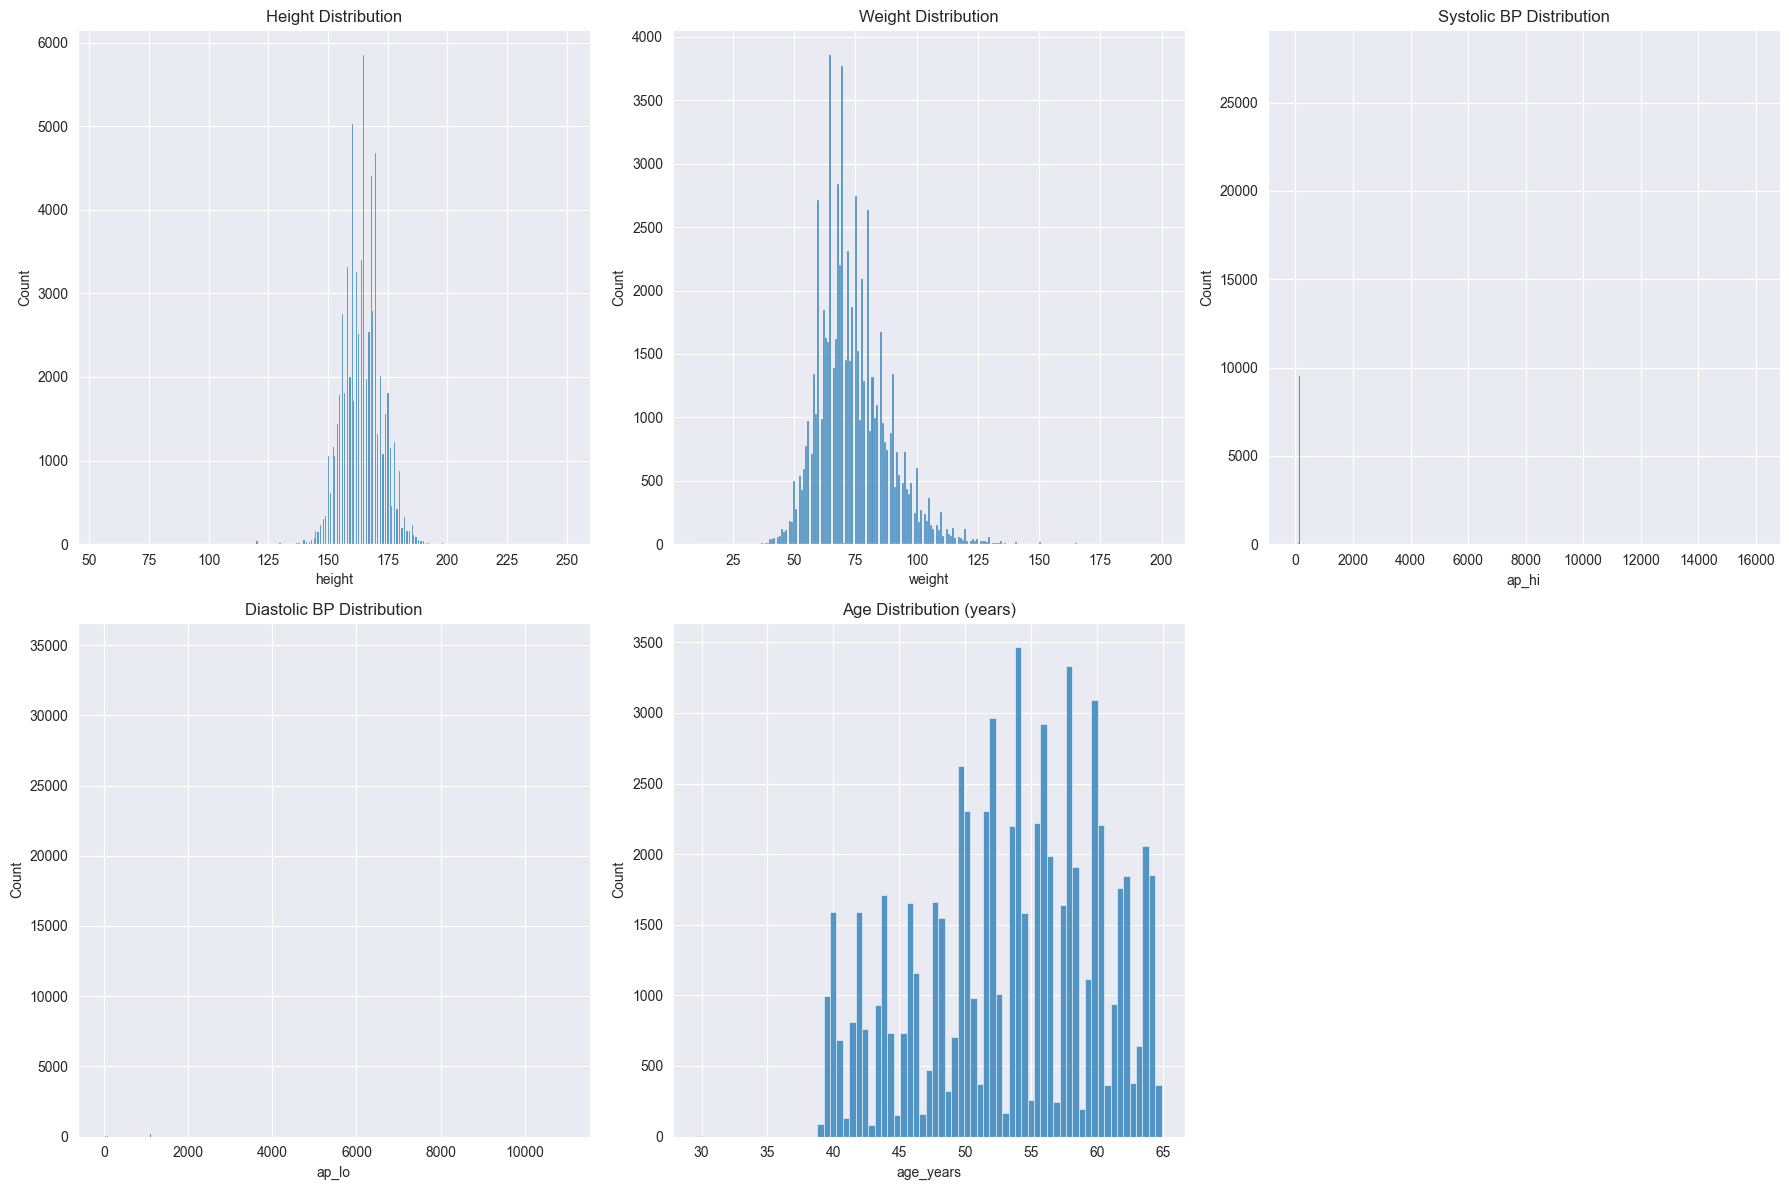

In [7]:
# Start data cleaning

# 1. Create a copy of the raw data
cardio_clean = cardioRaw.copy()

# 2. Convert age from days to years (assume 365.25 days per year)
cardio_clean['age_years'] = np.round(cardio_clean['age'] / 365.25, 1)

# 3. Check for outliers in height, weight, and blood pressure
plt.figure(figsize=(18, 12))

# Height distribution
plt.subplot(2, 3, 1)
sns.histplot(cardio_clean['height'])
plt.title('Height Distribution')

# Weight distribution
plt.subplot(2, 3, 2)
sns.histplot(cardio_clean['weight'])
plt.title('Weight Distribution')

# Systolic blood pressure
plt.subplot(2, 3, 3)
sns.histplot(cardio_clean['ap_hi'])
plt.title('Systolic BP Distribution')

# Diastolic blood pressure
plt.subplot(2, 3, 4)
sns.histplot(cardio_clean['ap_lo'])
plt.title('Diastolic BP Distribution')

# Age in years
plt.subplot(2, 3, 5)
sns.histplot(cardio_clean['age_years'])
plt.title('Age Distribution (years)')

plt.tight_layout()
plt.show()


In [8]:
# 4. Define realistic ranges for physical measurements and handle outliers

# Height limits (cm): typically between 140-220 cm for adults
cardio_clean = cardio_clean[(cardio_clean['height'] >= 140) & (cardio_clean['height'] <= 220)]

# Weight limits (kg): typically between 40-200 kg for adults
cardio_clean = cardio_clean[(cardio_clean['weight'] >= 40) & (cardio_clean['weight'] <= 200)]

# Blood pressure limits
# Systolic: 80-220 mmHg (extreme cases can reach 250, but rare)
# Diastolic: 40-120 mmHg (extreme cases can reach 130, but rare)
cardio_clean = cardio_clean[(cardio_clean['ap_hi'] >= 80) & (cardio_clean['ap_hi'] <= 220)]
cardio_clean = cardio_clean[(cardio_clean['ap_lo'] >= 40) & (cardio_clean['ap_lo'] <= 120)]

# Logical constraint: systolic pressure should be greater than diastolic
cardio_clean = cardio_clean[cardio_clean['ap_hi'] > cardio_clean['ap_lo']]

# 5. Create BMI feature
cardio_clean['bmi'] = np.round(cardio_clean['weight'] / ((cardio_clean['height']/100) ** 2), 1)

# 6. Categorize BMI
cardio_clean['bmi_category'] = pd.cut(
    cardio_clean['bmi'],
    bins=[0, 18.5, 25, 30, 100],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)


In [9]:
# 7. Convert categorical variables to appropriate format

# Convert categorical features to proper dtype
cat_features = ['cholesterol', 'gluc', 'smoke', 'alco', 'active', 'gender', 'cardio']
for feature in cat_features:
    cardio_clean[feature] = cardio_clean[feature].astype('category')

# Create blood pressure categories based on medical standards
cardio_clean['bp_category'] = 'Normal'
# Elevated: Systolic 120-129 and diastolic < 80
cardio_clean.loc[(cardio_clean['ap_hi'] >= 120) & (cardio_clean['ap_hi'] <= 129) &
               (cardio_clean['ap_lo'] < 80), 'bp_category'] = 'Elevated'
# Stage 1: Systolic 130-139 or diastolic 80-89
cardio_clean.loc[((cardio_clean['ap_hi'] >= 130) & (cardio_clean['ap_hi'] <= 139)) |
               ((cardio_clean['ap_lo'] >= 80) & (cardio_clean['ap_lo'] <= 89)), 'bp_category'] = 'Hypertension_1'
# Stage 2: Systolic >= 140 or diastolic >= 90
cardio_clean.loc[(cardio_clean['ap_hi'] >= 140) | (cardio_clean['ap_lo'] >= 90), 'bp_category'] = 'Hypertension_2'

cardio_clean['bp_category'] = cardio_clean['bp_category'].astype('category')


In [10]:
# 8. Check dataset after cleaning
print(f"Original shape: {cardioRaw.shape}, Clean shape: {cardio_clean.shape}")
print(f"Removed {cardioRaw.shape[0] - cardio_clean.shape[0]} outliers or invalid records")


Original shape: (70000, 13), Clean shape: (68425, 17)
Removed 1575 outliers or invalid records


In [11]:
# 9. Create feature for pulse pressure (difference between systolic and diastolic)
cardio_clean['pulse_pressure'] = cardio_clean['ap_hi'] - cardio_clean['ap_lo']


In [12]:
# 10. Feature engineering: create risk factors count
# Count risk factors: high cholesterol, high glucose, smoking, alcohol, inactive, high BMI, high BP
cardio_clean['bp_category'] = pd.Categorical(
    cardio_clean['bp_category'],
    categories=['Normal', 'Prehypertension', 'Hypertension_1', 'Hypertension_2'],
    ordered=True
)

# Update risk_factors calculation
cardio_clean['risk_factors'] = (
    (cardio_clean['cholesterol'] != 1).astype(int) +
    (cardio_clean['gluc'] != 1).astype(int) +
    (cardio_clean['smoke'] == 1).astype(int) +
    (cardio_clean['alco'] == 1).astype(int) +
    (cardio_clean['active'] == 0).astype(int) +
    (cardio_clean['bmi'] >= 30).astype(int) +
    (cardio_clean['bp_category']
        .isin(['Hypertension_1', 'Hypertension_2'])).astype(int)
)


In [13]:
# 11. Save the cleaned dataset
cardio_clean.to_parquet('./cardio_clean.parquet', engine='fastparquet')


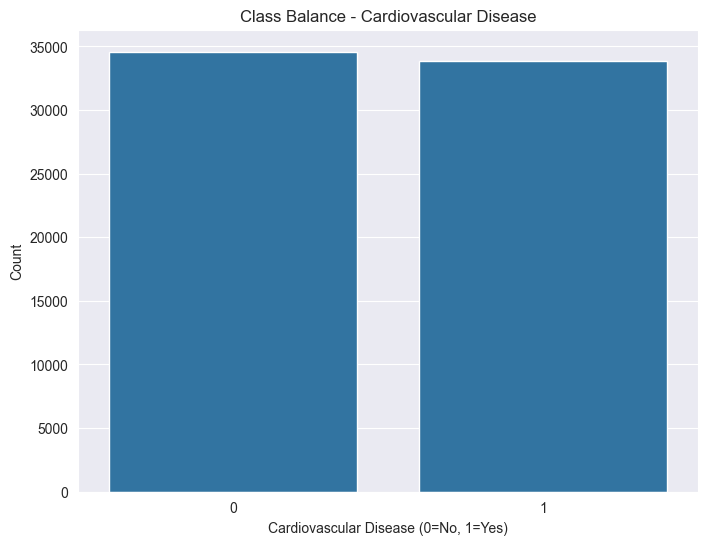

Class distribution:
cardio
0    0.5054
1    0.4946
Name: proportion, dtype: float64


In [14]:
# 12. Check class balance of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='cardio', data=cardio_clean)
plt.title('Class Balance - Cardiovascular Disease')
plt.ylabel('Count')
plt.xlabel('Cardiovascular Disease (0=No, 1=Yes)')
plt.show()

print("Class distribution:")
print(cardio_clean['cardio'].value_counts(normalize=True))


In [18]:
# 13. Prepare dataset for modeling
cardio_clean=pd.read_parquet('./cardio_clean.parquet')
# Create feature and target variables
X = cardio_clean.drop(['cardio', 'age', 'id'], axis=1, errors='ignore')
y = cardio_clean['cardio']

# Display the final features for modeling
print("Features available for modeling:")
print(X.columns.tolist())

# Verify that the cleaned dataset is ready for modeling
print(f"\nFeature dataset shape: {X.shape}")
print(f"Target dataset shape: {y.shape}")
# Explore dataset structure
print("Dataset shape:", cardioRaw.shape)
cardioRaw.head()

Features available for modeling:
['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_years', 'bmi', 'bmi_category', 'bp_category', 'pulse_pressure', 'risk_factors']

Feature dataset shape: (68425, 16)
Target dataset shape: (68425,)
Dataset shape: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [19]:
# Identifying categorical and numeric columns
categorical_columns = ["gender", "cholesterol", "gluc", "smoke", "alco", "active", "bp_category"]
numeric_columns = ["height", "weight", "age_years", "ap_hi", "ap_lo", "bmi"]

# Preprocessing pipeline (one-hot encoding for categorical, scaling for numeric)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_columns),
        ("cat", OneHotEncoder(drop="first"), categorical_columns),
    ]
)

# Apply preprocessing to the entire dataset before splitting
X_processed = preprocessor.fit_transform(X)

# Splitting the dataset (80%, 10%, 10%)
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)
X_validate, X_test, y_validate, y_test = train_test_split(
    X_holdout, y_holdout, test_size=0.5, random_state=42, stratify=y_holdout
)

# Convert processed data back to Pandas DataFrame (optional for saving)
# Obtain feature names after preprocessing
categorical_features_encoded = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_columns)
all_feature_names = numeric_columns + list(categorical_features_encoded)

X_train = pd.DataFrame(X_train, columns=all_feature_names)
X_validate = pd.DataFrame(X_validate, columns=all_feature_names)
X_test = pd.DataFrame(X_test, columns=all_feature_names)

# Save splits to Parquet
X_train.to_parquet("./cardio_split/X_train.parquet", engine="fastparquet")
pd.DataFrame(y_train).to_parquet("./cardio_split/Y_train.parquet", engine="fastparquet")

X_validate.to_parquet("./cardio_split/X_validate.parquet", engine="fastparquet")
pd.DataFrame(y_validate).to_parquet("./cardio_split/Y_validate.parquet", engine="fastparquet")

X_test.to_parquet("./cardio_split/X_test.parquet", engine="fastparquet")
pd.DataFrame(y_test).to_parquet("./cardio_split/Y_test.parquet", engine="fastparquet")

# Output dimensions for verification
print(f"X_train shape: {X_train.shape}, Y_train shape: {len(y_train)}")
print(f"X_validate shape: {X_validate.shape}, Y_validate shape: {len(y_validate)}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {len(y_test)}")


X_train shape: (54740, 17), Y_train shape: 54740
X_validate shape: (6842, 17), Y_validate shape: 6842
X_test shape: (6843, 17), Y_test shape: 6843
